# Feature Engineering Notebook

## Objectives

*   Engineer features for Regression models


## Inputs

* outputs/datasets/cleaned/TrainSetCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv

## Outputs

* Generate a list of variables to engineer

## Conclusions



* Feature Engineering Transformers
  * Ordinal categorical encoding: []
  * Numerical transformation: []
  * Smart Correlation Selection: []

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

---

# Load Cleaned Data

### Train Set

In [4]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,1828,0.0,2.883272,Av,48,None,1774,774,Unf,1828,...,11694,90.0,452.0,108,5,9,1822,2007,2007,314813
1,894,0.0,2.000000,No,0,Unf,894,308,None,894,...,6600,60.0,0.0,0,5,5,894,1962,1962,109500
2,964,0.0,2.000000,No,713,ALQ,163,432,Unf,964,...,13360,80.0,0.0,0,7,5,876,1921,2006,163500


Check there are no missing values

In [5]:
vars_with_missing_data = TrainSet.columns[TrainSet.isna().sum() > 0].to_list()
vars_with_missing_data

[]

### Test Set

In [6]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,2515,0.0,4.0,No,1219,Rec,816,484,None,2515,...,32668,71.75102,0.0,0,3,6,2035,1957,1975,200624
1,958,620.0,3.0,No,403,BLQ,238,240,Unf,1578,...,9490,79.00000,0.0,0,7,6,806,1941,1950,133000
2,979,224.0,3.0,No,185,LwQ,524,352,Unf,1203,...,7015,71.75102,161.0,0,4,5,709,1950,1950,110000


Check if there are missing values

In [7]:
vars_with_missing_data = TestSet.columns[TestSet.isna().sum() > 0].to_list()
vars_with_missing_data

[]

# Data Exploration

Generate pandas profiling report

In [ ]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

* From the pandas profiling report, we note that many variables have skewed distributions, some with outliers and others with many zeros.

* As our data set has numerical and categorical variables, we will explore the many potential feature engineering methods we can use to transform the features.


# Feature Engineering

### Create new feature(s)

* We have seen in the correlation study that the size of the properties is correlated with the sales prices. So we consider creating a custom variable that represent the total surface area of a property.

* We calculate the total surface by adding the total basement, first and second floor surface areas.

In [9]:
for df in [TrainSet, TestSet]:
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

In [10]:
vars_with_missing_data = TrainSet.columns[TrainSet.isna().sum() > 0].to_list()
vars_with_missing_data

[]

In [11]:
TrainSet['TotalSF'].describe()

count    1168.000000
mean     2548.071062
std       782.282270
min       334.000000
25%      1983.750000
50%      2467.000000
75%      2999.250000
max      7814.000000
Name: TotalSF, dtype: float64

In [12]:
TestSet['TotalSF'].describe()

count      292.000000
mean      2547.969178
std        989.202651
min        930.000000
25%       1970.000000
50%       2421.500000
75%       2955.250000
max      11752.000000
Name: TotalSF, dtype: float64

We visualize the joint distributions SalePrice and TotalSF.

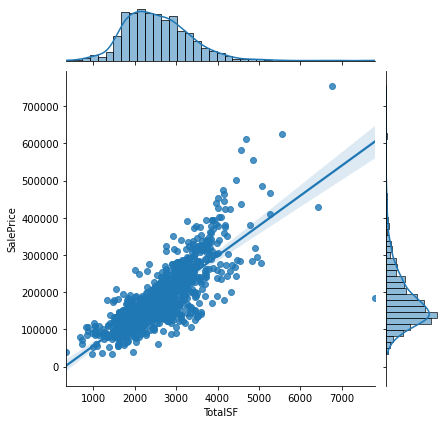

In [13]:
import seaborn as sns
sns.jointplot(y=TrainSet['SalePrice'],x=TrainSet['TotalSF'],kind="reg")

* We note that both move in the same direction, indicating that TotalSF may be a good predictor of SalePrice.

* From the meta data, we know that the value of YearRemodAdd is the same as YearBuilt if no remodeling was made for the house. In the event that these two variables have the same value for many houses in our data, the former may be redundant.

* We count the number of houses with YearRemodAdd==YearBuilt. If this happens to be the case for a significant proportion of the houses, we can consider converting YearRemodAdd to a binary variable with 1 if the house was remodeled, 0 otherwise. 

In [14]:
for df in [TestSet, TrainSet]:
    no_remodel_added = df[df['YearBuilt']==df['YearRemodAdd']]['YearRemodAdd'].count()
    print(no_remodel_added)
    print(df.shape)
    print(no_remodel_added/df.shape[0])

156
(292, 22)
0.5342465753424658
608
(1168, 22)
0.5205479452054794


* More than half of the houses in both the TrainSet and TestSet did not get any remodeling added.

* This shows that keeping YearRemodAdd as it is will not make much sense. We will create a custom variable to avoid redundancy while making use of the available information to improve the predictions we want to make.

In [15]:
import numpy as np
for df in [TrainSet, TestSet]:
    df['RemodAdded'] = np.where(df['YearBuilt']==df['YearRemodAdd'], 0, 1)

TrainSet.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice,TotalSF,RemodAdded
0,1828,0.0,2.883272,Av,48,None,1774,774,Unf,1828,...,452.0,108,5,9,1822,2007,2007,314813,3650.0,0
1,894,0.0,2.000000,No,0,Unf,894,308,None,894,...,0.0,0,5,5,894,1962,1962,109500,1788.0,0
2,964,0.0,2.000000,No,713,ALQ,163,432,Unf,964,...,0.0,0,7,5,876,1921,2006,163500,1840.0,1
3,1689,0.0,3.000000,No,1218,GLQ,350,857,RFn,1689,...,148.0,59,5,8,1568,2002,2002,271000,3257.0,0
4,1541,0.0,3.000000,No,0,Unf,1541,843,RFn,1541,...,150.0,81,5,7,1541,2001,2002,205000,3082.0,1


## Custom functions

* The following custom functions was copied and adapted from the walkthrough project on customer churn study, feature engineering notebook. 

* We use this custom functions for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape. 

* After applying the transformations, we use its reporting tool, like pandas-profiling, to evaluate distributions.

In [16]:
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df,analysis_type=None):


  """
  - used for quick feature engineering on numerical and categorical variables
  to decide which transformation can better transform the distribution shape 
  - Once transformed, use a reporting tool, like pandas-profiling, to evaluate distributions

  """
  check_missing_values(df)
  allowed_types= ['numerical', 'ordinal_encoder',  'outlier_winsorizer']
  check_user_entry_on_analysis_type(analysis_type, allowed_types)
  list_column_transformers = define_list_column_transformers(analysis_type)
  
  
  # Loop in each variable and engineer the data according to the analysis type
  df_feat_eng = pd.DataFrame([])
  for column in df.columns:
    # create additional columns (column_method) to apply the methods
    df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
    for method in list_column_transformers:
      df_feat_eng[f"{column}_{method}"] = df[column]
      
    # Apply transformers in respectives column_transformers
    df_feat_eng,list_applied_transformers = apply_transformers(analysis_type, df_feat_eng, column)

    # For each variable, assess how the transformations perform
    transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng)

  return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
  ### Check analyis type
  if analysis_type == None:
    raise SystemExit(f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
  if analysis_type not in allowed_types:
      raise SystemExit(f"analysis_type argument should be one of these options: {allowed_types}")

def check_missing_values(df):
  if df.isna().sum().sum() != 0:
    raise SystemExit(
        f"There is missing value in your dataset. Please handle that before getting into feature engineering.")



def define_list_column_transformers(analysis_type):
  ### Set suffix colummns acording to analysis_type
  if analysis_type=='numerical':
    list_column_transformers = ["log_e","log_10","reciprocal", "power","box_cox","yeo_johnson"]
  
  elif analysis_type=='ordinal_encoder':
    list_column_transformers = ["ordinal_encoder"]

  elif analysis_type=='outlier_winsorizer':
    list_column_transformers = ['iqr']

  return list_column_transformers



def apply_transformers(analysis_type, df_feat_eng, column):


  for col in df_feat_eng.select_dtypes(include='category').columns:
    df_feat_eng[col] = df_feat_eng[col].astype('object')


  if analysis_type=='numerical':
    df_feat_eng,list_applied_transformers = FeatEngineering_Numerical(df_feat_eng,column)
  
  elif analysis_type=='outlier_winsorizer':
    df_feat_eng,list_applied_transformers = FeatEngineering_OutlierWinsorizer(df_feat_eng,column)

  elif analysis_type=='ordinal_encoder':
    df_feat_eng,list_applied_transformers = FeatEngineering_CategoricalEncoder(df_feat_eng,column)

  return df_feat_eng,list_applied_transformers



def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
  # For each variable, assess how the transformations perform
  print(f"* Variable Analyzed: {column}")
  print(f"* Applied transformation: {list_applied_transformers} \n")
  for col in [column] + list_applied_transformers:
    
    if analysis_type!='ordinal_encoder':
      DiagnosticPlots_Numerical(df_feat_eng, col)
    
    else:
      if col == column: 
        DiagnosticPlots_Categories(df_feat_eng, col)
      else:
        DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
  plt.figure(figsize=(4, 3))
  sns.countplot(data=df_feat_eng, x=col,palette=['#432371'],order = df_feat_eng[col].value_counts().index)
  plt.xticks(rotation=90) 
  plt.suptitle(f"{col}", fontsize=30,y=1.05)        
  plt.show()
  print("\n")



def DiagnosticPlots_Numerical(df, variable):
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  sns.histplot(data=df, x=variable, kde=True,element="step",ax=axes[0]) 
  stats.probplot(df[variable], dist="norm", plot=axes[1])
  sns.boxplot(x=df[variable],ax=axes[2])
  
  axes[0].set_title('Histogram')
  axes[1].set_title('QQ Plot')
  axes[2].set_title('Boxplot')
  fig.suptitle(f"{variable}", fontsize=30,y=1.05)
  plt.tight_layout()
  plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng,column):
  list_methods_worked = []
  try:  
    encoder= OrdinalEncoder(encoding_method='arbitrary', variables = [f"{column}_ordinal_encoder"])
    df_feat_eng = encoder.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_ordinal_encoder")
  
  except: 
    df_feat_eng.drop([f"{column}_ordinal_encoder"],axis=1,inplace=True)
    
  return df_feat_eng,list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng,column):
  list_methods_worked = []

  ### Winsorizer iqr
  try: 
    disc=Winsorizer(
        capping_method='iqr', tail='both', fold=1.5, variables = [f"{column}_iqr"])
    df_feat_eng = disc.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_iqr")
  except: 
    df_feat_eng.drop([f"{column}_iqr"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked




def FeatEngineering_Numerical(df_feat_eng,column):

  list_methods_worked = []

  ### LogTransformer base e
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_e"])
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_e")
  except: 
    df_feat_eng.drop([f"{column}_log_e"],axis=1,inplace=True)

    ### LogTransformer base 10
  try: 
    lt = vt.LogTransformer(variables = [f"{column}_log_10"],base='10')
    df_feat_eng = lt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_log_10")
  except: 
    df_feat_eng.drop([f"{column}_log_10"],axis=1,inplace=True)

  ### ReciprocalTransformer
  try:
    rt = vt.ReciprocalTransformer(variables = [f"{column}_reciprocal"])
    df_feat_eng =  rt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_reciprocal")
  except:
    df_feat_eng.drop([f"{column}_reciprocal"],axis=1,inplace=True)

  ### PowerTransformer
  try:
    pt = vt.PowerTransformer(variables = [f"{column}_power"])
    df_feat_eng = pt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_power")
  except:
    df_feat_eng.drop([f"{column}_power"],axis=1,inplace=True)

  ### BoxCoxTransformer
  try:
    bct = vt.BoxCoxTransformer(variables = [f"{column}_box_cox"])
    df_feat_eng = bct.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_box_cox")
  except:
    df_feat_eng.drop([f"{column}_box_cox"],axis=1,inplace=True)


  ### YeoJohnsonTransformer
  try:
    yjt = vt.YeoJohnsonTransformer(variables = [f"{column}_yeo_johnson"])
    df_feat_eng = yjt.fit_transform(df_feat_eng)
    list_methods_worked.append(f"{column}_yeo_johnson")
  except:
        df_feat_eng.drop([f"{column}_yeo_johnson"],axis=1,inplace=True)


  return df_feat_eng,list_methods_worked


## Feature Engineering Summary
The transformers for this dataset will be:
  * Categorical Encoding
  * Numerical Transformation
  * Smart Correlation Selection

## Dealing with Feature Engineering

### 1. Ordinal categorical encoding

* The following variables have been selected for ordinal categorical encoding

In [17]:
variables_engineering= ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

* Now we create a dataframe consisting of these variables 

In [18]:
df_engineering = TrainSet[variables_engineering].copy()

* We apply the above FeatureEngineeringAnalysis function

* Variable Analyzed: BsmtExposure
* Applied transformation: ['BsmtExposure_ordinal_encoder'] 



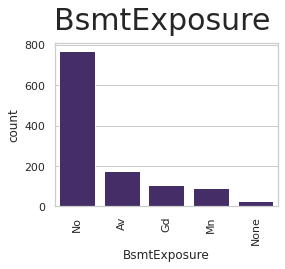

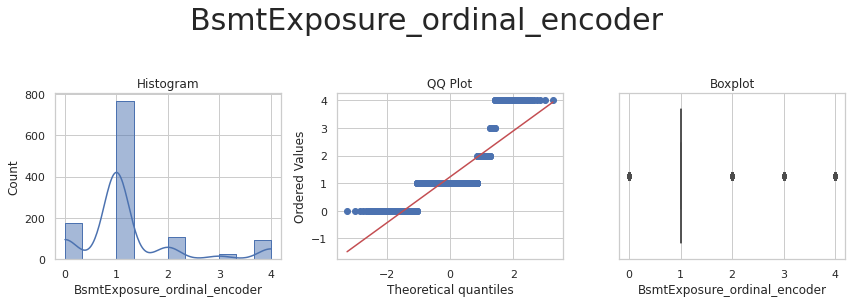



* Variable Analyzed: BsmtFinType1
* Applied transformation: ['BsmtFinType1_ordinal_encoder'] 



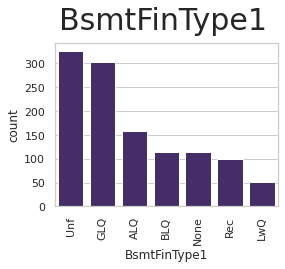

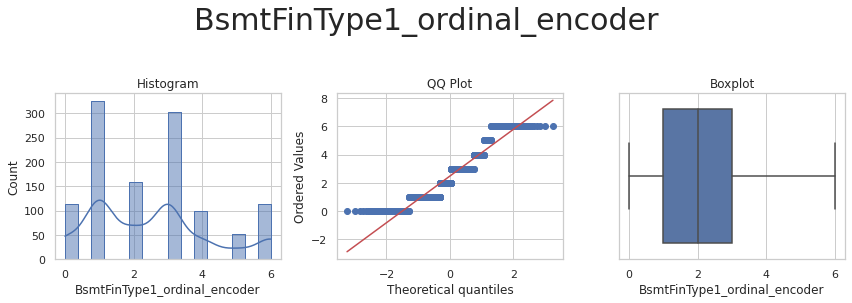



* Variable Analyzed: GarageFinish
* Applied transformation: ['GarageFinish_ordinal_encoder'] 



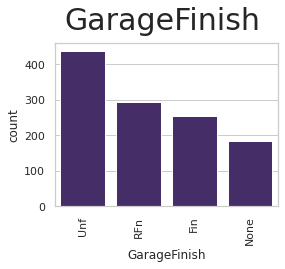

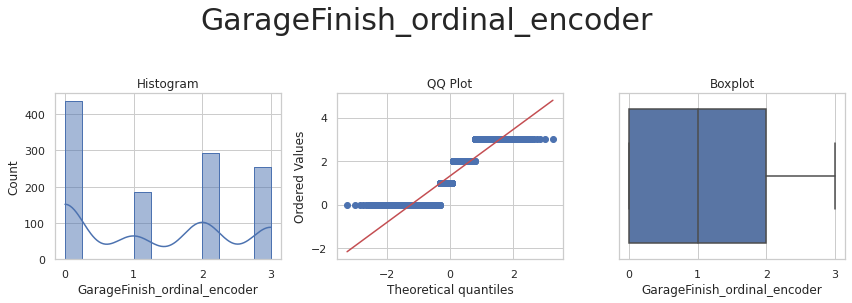



* Variable Analyzed: KitchenQual
* Applied transformation: ['KitchenQual_ordinal_encoder'] 



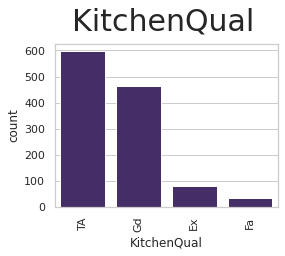

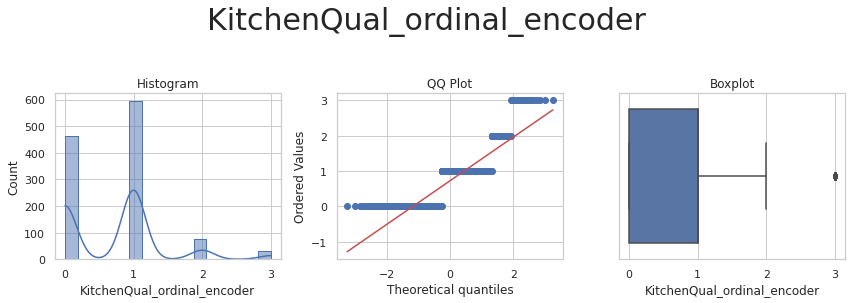

In [19]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='ordinal_encoder')

* Our ordinal categorical encoding transformation has effectively converted the categories of each variable to numbers.

* Now we apply this transformation to the Train and Test datasets

In [20]:
encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_engineering)
TrainSet = encoder.fit_transform(TrainSet)
TestSet = encoder.fit_transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!


### 2. Numerical Transformation

* The variables for numerical transformation are the following.

In [28]:
variables_engineering = ['1stFlrSF', '2ndFlrSF', 'BsmtUnfSF', 'GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', 'TotalSF']

* We apply similar step as above and create a separate dataframe

In [26]:
df_engineering = TrainSet[variables_engineering].copy()

* Apply the transformation and assess the distributions

In [ ]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='numerical')

Fromt the numerical transformations, We make the following note:

* Log tranformation is helpful to normalize variables with large numbers so that the gap between the many zeros and the rest of the values is rendered smaller. We will apply the log_e transformation to 1stFlrSF, GrLivArea, LotArea and LotFrontage.

* TotalSF appears to have comparable distributions when we use power, box_cox and jeo_jhonson transformations. We will use power transformation. 

* Many of the other variables have substantial frequencies of zero values, and despite the little change in the distributions after applying any of the transformations, the power transformer has better normalized the range of values. So we will use this transformation to 2ndFlrSF, BsmtUnfSF, GarageArea, MasVnrArea, OpenPorchSF, and TotalBsmtSF.

In [30]:
lt = vt.LogTransformer(variables = ['1stFlrSF', 'GrLivArea', 'LotArea', 'LotFrontage'])
pt = vt.PowerTransformer(variables = ['2ndFlrSF', 
                                        'BsmtUnfSF', 
                                        'GarageArea', 
                                        'GrLivArea', 
                                        'MasVnrArea', 
                                        'OpenPorchSF', 
                                        'TotalBsmtSF', 
                                        'TotalSF'])

transformers = [lt, pt]
for t in transformers:
    TrainSet = t.fit_transform(TrainSet)
    TestSet = t.fit_transform(TestSet)

print("* Numerical transformation done!")

* Numerical transformation done!


### 3. Winsoriser

* Select variables with potential outliers

In [32]:
variables_engineering = ['BsmtUnfSF','GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', 'TotalSF']

* We apply similar step as above and create a separate dataframe

In [33]:
df_engineering = TrainSet[variables_engineering].copy()

* Apply the transformation and assess the distributions

In [ ]:
df_engineering = FeatureEngineeringAnalysis(df=df_engineering, analysis_type='outlier_winsorizer')

* We apply the winsoriser to the train and test datasets.

In [ ]:
winsoriser = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables = variables_engineering)
TrainSet = winsoriser.fit_transform(TrainSet)
TestSet = winsoriser.fit_transform(TestSet)

print("* Outlier winsoriser transformation done!")

### 4. SmartCorrelatedSelection Variables

In [ ]:
df_engineering = TrainSet.copy()

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection
corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6,selection_method="variance")

corr_sel.fit_transform(df_engineering)
corr_sel.correlated_feature_sets_

In [ ]:
corr_sel.features_to_drop_

# Conclusions and Next Steps

* Ordinal categorical encoding: ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
* Numerical transformation: ['GrLivArea', 'LotFrontage', 'TotalSF']
* Outlier winsoriser: ['BsmtUnfSF','GarageArea', 'GrLivArea', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', 'TotalSF']
* Smart Correlation Selection: ['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalSF']